In [36]:
# import libraries
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
# from pyspark.sql.types import IntegerType
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import StringIndexer
# from pyspark.ml.feature import OneHotEncoderEstimator
# from pyspark.ml.feature import StandardScaler
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml.classification import DecisionTreeClassifier
# from pyspark.ml.feature import Normalizer
# import pingouin as pg


In [2]:
# Create spark session
spark = SparkSession.builder.master("local[*]").appName('Analysis').getOrCreate()

# Load excel datasets into pandas dataframes
ref = pd.read_excel('./datasets/reccrime-offence-ref.xlsx')
tables = pd.read_excel('./datasets/prc-pfa-mar2013-onwards-tables-191023.xlsx', sheet_name=None)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/04 23:28:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Select the table of interest and create a dataframe
yr_2019_20 = tables['2019-20']
yr_2020_21 = tables['2020-21']
yr_2021_22 = tables['2021-22']
yr_2022_23 = tables['2022-23']
yr_2023_24 = tables['2023-24']

In [4]:
# Convert table  and offence_ref_ps to pyspark dataframe
offence_ref = spark.createDataFrame(ref)
df_2019_20 = spark.createDataFrame(yr_2019_20)
df_2020_21 = spark.createDataFrame(yr_2020_21)
df_2021_22 = spark.createDataFrame(yr_2021_22)
df_2022_23 = spark.createDataFrame(yr_2022_23)
df_2023_24 = spark.createDataFrame(yr_2023_24)

In [5]:
# Create temporary views of the dataframes
df_2019_20.createOrReplaceTempView('df_2019_20')
df_2020_21.createOrReplaceTempView('df_2020_21')
df_2021_22.createOrReplaceTempView('df_2021_22')
df_2022_23.createOrReplaceTempView('df_2022_23')
df_2023_24.createOrReplaceTempView('df_2023_24')

# Write sql queries to join tables
query_1 = """
                SELECT * FROM df_2019_20
                UNION
                SELECT * FROM df_2020_21
                UNION 
                SELECT * FROM df_2021_22
                UNION
                SELECT * FROM df_2022_23
                UNION
                SELECT * FROM df_2023_24
"""

# Load query and return dataframe
offence_df = spark.sql(query_1)

In [6]:
# Rename col to remove white space
rename_cols = {
                'Financial Year': 'Financial_Year',
                'Financial Quarter':'Financial_Quarter',
                'Force Name':'Force_Name',
                'Offence Description':'Offence_Description',
                'Offence Group':'Offence_Group',
                'Offence Subgroup':'Offence_Subgroup',
                'Offence Code':'Offence_Code',
                'Number of Offences':'Number_of_Offences',
                'Old PRC offence group': 'Old_PRC_offence_group',
                'Old offence sub-group': 'Old_offence_sub-group',
                'New ONS offence group': 'New_ONS_offence_group',
                'New ONS sub-offence group': 'New_ONS_sub-offence_group'
}

# Loops through rename_cols and removes white space
for old_name, new_name in rename_cols.items():
    offence_df = offence_df.withColumnRenamed(old_name, new_name)
    offence_ref = offence_ref.withColumnRenamed(old_name, new_name)


In [7]:
# Drop duplicates in offence_ref
offence_ref = offence_ref.dropDuplicates()

# Create temporary views of the dataframes
offence_df.createOrReplaceTempView('offence_df')
offence_ref.createOrReplaceTempView('offence_ref')

# Write sql query to join tables 
query_2 = """
                    SELECT * FROM offence_df
                    INNER JOIN offence_ref 
                    ON offence_df.Offence_Code = offence_ref.Offence_Code;
                """

#  Create offence_final with query
offence_final = spark.sql(query_2)

In [8]:
# Print schema 
offence_final.printSchema()

root
 |-- Financial_Year: string (nullable = true)
 |-- Financial_Quarter: long (nullable = true)
 |-- Force_Name: string (nullable = true)
 |-- Offence_Description: string (nullable = true)
 |-- Offence_Group: string (nullable = true)
 |-- Offence_Subgroup: string (nullable = true)
 |-- Offence_Code: string (nullable = true)
 |-- Number_of_Offences: long (nullable = true)
 |-- Offence_Code: string (nullable = true)
 |-- Offence_Description: string (nullable = true)
 |-- Old_PRC_offence_group: string (nullable = true)
 |-- Old_offence_sub-group: string (nullable = true)
 |-- New_ONS_offence_group: string (nullable = true)
 |-- New_ONS_sub-offence_group: string (nullable = true)



In [9]:
# Get year from financial year column
offence_final = offence_final.withColumn('Financial_Year', substring('Financial_Year',  1,  4))

# Convert Financial year column to int
offence_final = offence_final.withColumn('Financial_Year',  offence_final.Financial_Year.cast('int'))

In [10]:
offence_final.printSchema()

root
 |-- Financial_Year: integer (nullable = true)
 |-- Financial_Quarter: long (nullable = true)
 |-- Force_Name: string (nullable = true)
 |-- Offence_Description: string (nullable = true)
 |-- Offence_Group: string (nullable = true)
 |-- Offence_Subgroup: string (nullable = true)
 |-- Offence_Code: string (nullable = true)
 |-- Number_of_Offences: long (nullable = true)
 |-- Offence_Code: string (nullable = true)
 |-- Offence_Description: string (nullable = true)
 |-- Old_PRC_offence_group: string (nullable = true)
 |-- Old_offence_sub-group: string (nullable = true)
 |-- New_ONS_offence_group: string (nullable = true)
 |-- New_ONS_sub-offence_group: string (nullable = true)



In [11]:
# Descriptive statistics of  Numeric Column
offence_final.describe(['Number_of_Offences']).show()

+-------+------------------+
|summary|Number_of_Offences|
+-------+------------------+
|  count|             86768|
|   mean|218.72708832749402|
| stddev| 884.6202960002709|
|    min|                 0|
|    max|             29480|
+-------+------------------+



In [12]:
# Covariance of FInancial year anf Number of offences

In [13]:
# Covariance of FInancial quarter and Number of offences


In [14]:
# check for skewness of Number of Offences

<Axes: ylabel='Frequency'>

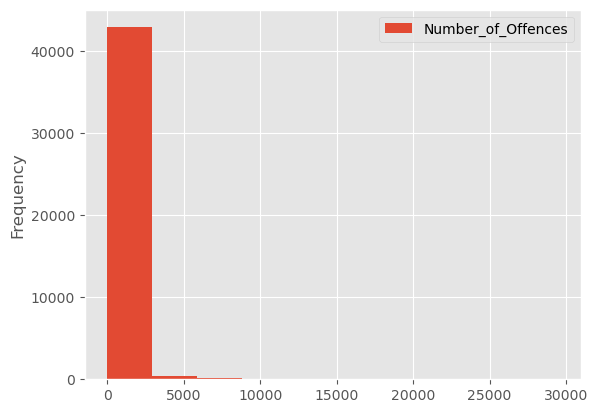

In [50]:
dd = offence_final.select('Number_of_Offences').sample(False, 0.50, 42).toPandas()


(0.0, 8000.0)

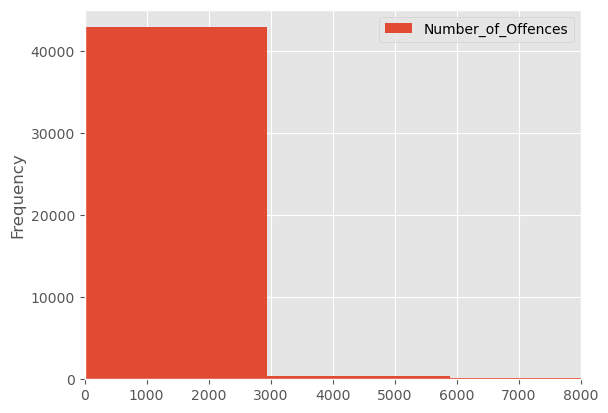

In [54]:
dd.plot(kind='hist')
plt.xlim(0, 8000)

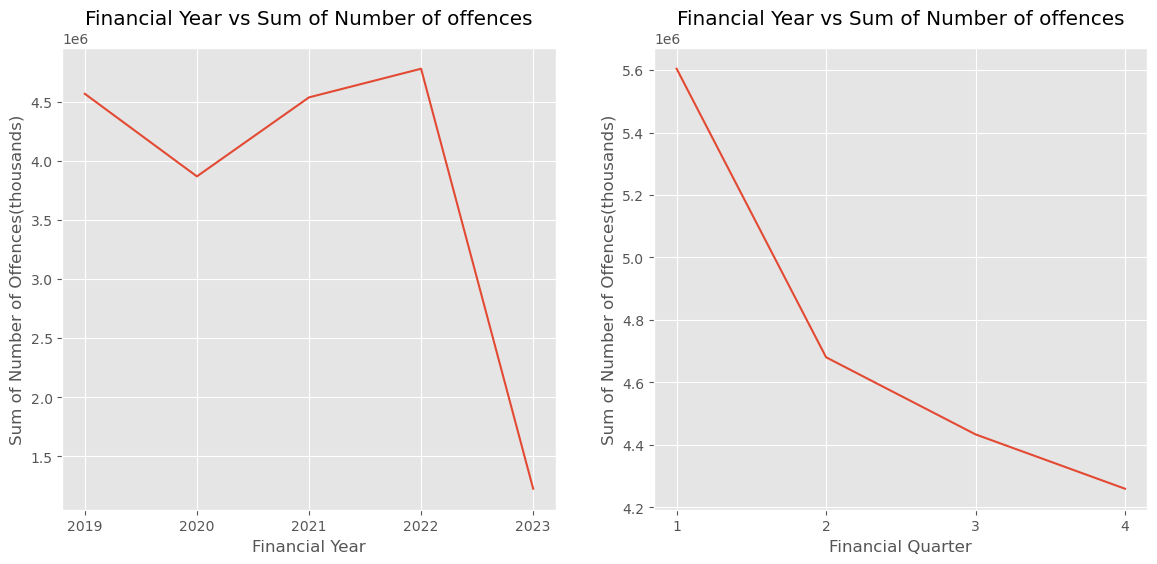

In [49]:
# Set the figure size for plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Group data by financial year and find the sum of each year
trends_1 = offence_final.groupBy('Financial_Year').sum('Number_of_Offences').toPandas()

# Group data by financial quarter and find the sum of each offences
trends_2 = offence_final.groupBy('Financial_Quarter').sum('Number_of_Offences').toPandas()

# Plot Trends_1
sns.lineplot(data=trends_1,  x='Financial_Year', y='sum(Number_of_Offences)',  
                                                                                    ax=ax[0]).set(title='Financial Year vs Sum of Number of offences',
                                                                                    xlabel='Financial Year',
                                                                                    ylabel='Sum of Number of Offences(thousands)',
                                                                                    xticks=[2019, 2020, 2021, 2022, 2023])
# Plot  Trends_2
sns.lineplot(data=trends_2,  x='Financial_Quarter', y='sum(Number_of_Offences)',  
                                                                                    ax=ax[1]).set(title='Financial Year vs Sum of Number of offences',
                                                                                    xlabel='Financial Quarter',
                                                                                    ylabel='Sum of Number of Offences(thousands)',
                                                                                    xticks=[1, 2, 3, 4],)
# Show plot
plt.show()

In [ ]:
;